In [2]:
import os
import pandas as pd
import numpy as np
import openslide
import matplotlib.pyplot as plt
from utils import get_TC, parse_patch_size, run_TC_one_slide
from utils import process_TCmask, bbx_overlay, get_roi_ids
from utils import parse_roi_id, show_roi, save_patchcsv, parse_patch_size, show_patch


In [3]:
wsi_pt = '/scratch/prj/cb_normalbreast/Siyuan/WSIs/BRCA2_SGK/K108383.svs'
mask_pt = '/scratch/prj/cb_normalbreast/Siyuan/WSI_QC/BRCA2_SGK/K108383.svs/K108383.svs_mask_use.png'
temp = '/scratch/prj/cb_normalbreast/Siyuan/temp'
weights = '/scratch/users/k21066795/prj_normal/ckpts/Tissue_Classifier.h5'

TC_maskpt = f"{temp}/TCprobmask.npy"
TC = get_TC(weights)

2024-08-17 08:24:28.058413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22291 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:b3:00.0, compute capability: 8.0
2024-08-17 08:24:28.060842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22291 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:b4:00.0, compute capability: 8.0
/scratch/users/k21066795/conda/tfgpu_env/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


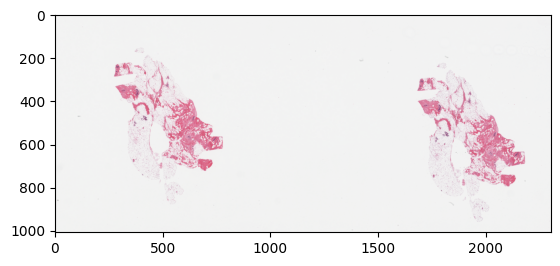

In [4]:
wsi = openslide.OpenSlide(wsi_pt)
img = wsi.read_region((0,0), wsi.level_count-1, wsi.level_dimensions[wsi.level_count-1]).convert('RGB')
plt.imshow(np.array(img))

(73703, 32286), (284, 124) compressed, in which 1284 tissue tiles.
Tiles are extracted at level 0, with a size of 259 
and a stride of 259 and downsampled with a factor of 1.
405.02720975875854 seconds to vectorise the slide!
Tissue-Classifier is predicting ...


/scratch/users/k21066795/prj_normal/Tissue-Classifier/utils.py:218: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  tc_predictions = TC.predict_generator(generator=wsi_sequence, steps=len(wsi_sequence),verbose=1)
2024-08-17 08:31:22.890797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800


  6/161 [>.............................] - ETA: 3s

2024-08-17 08:31:23.198695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


161/161 [==============================] - 5s 24ms/step


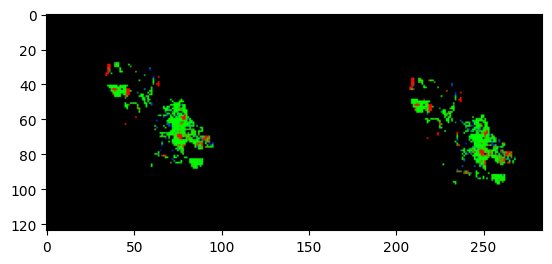

In [5]:
tissue_map = run_TC_one_slide(wsi, mask_pt, TC, temp, patch_size=128, foreground_thes=0.7)              
np.save(f"{temp}/TCprobmask.npy", tissue_map)
plt.imshow(tissue_map)

(-0.5, 9087.5, 3967.5, -0.5)

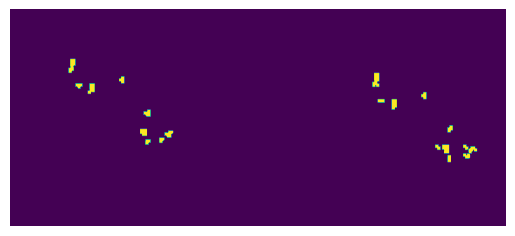

In [11]:
epi_mask, roi_width, wsi_mask_ratio = process_TCmask(wsi_pt, 
                                                     TC_maskpt, 
                                                     upsample=32, 
                                                     small_objects=50000, 
                                                     roi_width=250)
plt.imshow(epi_mask)
plt.axis('off')

(-0.5, 9087.5, 3967.5, -0.5)

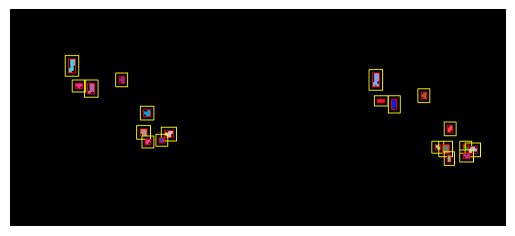

In [14]:
bbx_map = bbx_overlay(epi_mask=epi_mask, overlay_pt=f"{temp}/bbx.png", roi_width=roi_width) 
plt.imshow(bbx_map)
plt.axis('off')

(-0.5, 2034.5, 1515.5, -0.5)

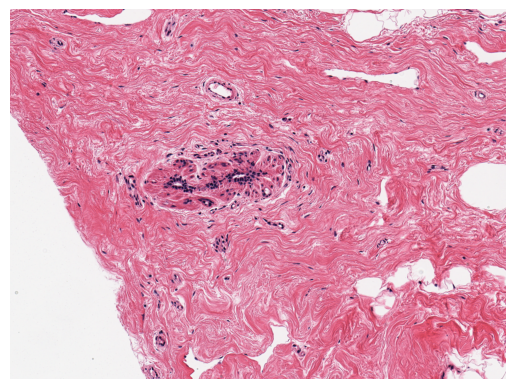

In [37]:
wsi_id = os.path.basename(wsi_pt).split('.')[0]
roi_ids = get_roi_ids(epi_mask, wsi_id, roi_width=roi_width, 
                      upsample=32, wsi_mask_ratio=wsi_mask_ratio)
im = show_roi(wsi, roi_ids[6])
plt.imshow(im)
plt.axis('off')

In [44]:
patch_size, _ = parse_patch_size(wsi, patch_size=128)
print(patch_size)
patch_df = save_patchcsv(roi_ids, patch_size, TC_maskpt, temp)
patch_df.head()

259
/scratch/prj/cb_normalbreast/Siyuan/temp/K108383_patch.csv saved!


,roi_id,patch_id,cls,TC_epi,TC_str,TC_adi,cohort,wsi_id
64,K108383_8191_6893_2035_3073,K108383_8191_6893_2035_3073_35_29_259,epithelium,0.999846,0.000154,9.694316e-08,temp,temp
65,K108383_8191_6893_2035_3073,K108383_8191_6893_2035_3073_36_29_259,epithelium,0.956154,0.040455,3.390869e-03,temp,temp
66,K108383_8191_6893_2035_3073,K108383_8191_6893_2035_3073_35_30_259,epithelium,0.999950,0.000049,6.206727e-08,temp,temp
67,K108383_8191_6893_2035_3073,K108383_8191_6893_2035_3073_36_30_259,epithelium,0.999264,0.000734,2.870652e-06,temp,temp
68,K108383_8191_6893_2035_3073,K108383_8191_6893_2035_3073_35_31_259,epithelium,0.647331,0.351211,1.457994e-03,temp,temp


(-0.5, 258.5, 258.5, -0.5)

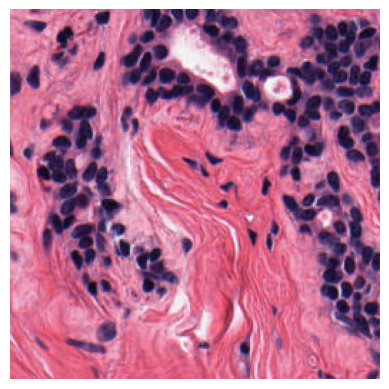

In [45]:
patch_id = list(patch_df['patch_id'][patch_df['cls']=='epithelium'])[2]
show_patch(wsi, patch_id)
plt.axis('off')